### GROUP PROJECT MASTER

In [1]:
# import libraries and dependencies
import os
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
from dotenv import load_dotenv
import yfinance as yf
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension('plotly')
import matplotlib.pyplot as plt
import hvplot.pandas
import seaborn as sns

load_dotenv()
%matplotlib inline

In [2]:
# read in datasets
df_sp500 = pd.read_csv("DATA SOURCES/sp500_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_dowjones = pd.read_csv("DATA SOURCES/dowjones_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_nasdaq = pd.read_csv("DATA SOURCES/nasdaq_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_gold = pd.read_csv("DATA SOURCES/gold_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_silver = pd.read_csv("DATA SOURCES/silver_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_crudeoil = pd.read_csv("DATA SOURCES/crudeoil_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
wti_df = pd.read_csv("DATA SOURCES/Crude_Oil_WTI.csv", index_col ="DATE", infer_datetime_format = True, parse_dates = True)
real_gdp = pd.read_csv("DATA SOURCES/Real_GDP_per_capita.csv",index_col='DATE', parse_dates=True, infer_datetime_format=True)
ir_data = pd.read_csv("DATA SOURCES/Real_GDP_per_capita.csv",index_col='DATE', parse_dates=True, infer_datetime_format=True)
prime_data = pd.read_csv('DATA SOURCES/USA Inflation (Monthly) 1980-2020.csv',index_col='Date',infer_datetime_format=True, parse_dates=True) 
hpi_data = pd.read_csv('DATA SOURCES/USA HPI (All Transactions, Quarterly) Jan 1975-July 2020.csv', index_col=['DATE'],infer_datetime_format=True, parse_dates=True)


In [3]:
# set, pull and display data from YFinance
dxy_df = yf.download('DX-Y.NYB',
                       start='1985-01-01',
                       end='2020-12-31',
                       progress=False,
                       index_col ='Date',
                       infer_datetime_format= True,
                       parse_dates = True,
                       interval='1mo'

)
dxy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,152.229996,153.889999,151.800003,152.720001,152.720001,0
1985-02-01,153.470001,164.720001,153.470001,160.410004,160.410004,0
1985-03-01,161.039993,163.830002,149.179993,149.179993,149.179993,0
1985-04-01,150.649994,153.160004,144.830002,149.699997,149.699997,0
1985-05-01,151.570007,154.520004,147.059998,147.860001,147.860001,0


## Data Cleaning

In [4]:
# drop unnecessary columns
df_sp500.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_dowjones.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_nasdaq.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_gold.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_silver.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_crudeoil.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
dxy_df.drop(['Open', 'High','Low', 'Adj Close', 'Volume'],axis=1, inplace=True)


In [5]:
# rename columns to indicate index / symbol
df_sp500.rename(columns={"Price":"sp500"},inplace=True)
df_dowjones.rename(columns={"Price":"dowjones"},inplace=True)
df_nasdaq.rename(columns={"Price":"nasdaq"},inplace=True)
df_gold.rename(columns={"Price":"gold"},inplace=True)
df_silver.rename(columns={"Price":"silver"},inplace=True)
df_crudeoil.rename(columns={"Price":"crude oil"},inplace=True)
dxy_df.rename(columns={'Close':'usd'}, inplace= True)
wti_df.rename(columns={'MCOILWTICO':'wti oil'}, inplace = True)
real_gdp.rename(columns={"A939RX0Q048SBEA": "gdp"},inplace=True)
ir_data.rename(columns={"A939RX0Q048SBEA": "interest rate"},inplace=True)
prime_data.rename(columns={"Inflation Rate":'prime rate'},inplace=True)
hpi_data.rename(columns={'USSTHPI':"house price index"},inplace=True)


In [6]:
# combine commodity datasets
df_commodities = pd.concat([df_sp500,df_dowjones,df_nasdaq,df_gold], join="inner", axis="columns")
df_commodities.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2021-01-01 to 1985-02-01
Freq: -1MS
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sp500     432 non-null    object
 1   dowjones  432 non-null    object
 2   nasdaq    432 non-null    object
 3   gold      432 non-null    object
dtypes: object(4)
memory usage: 16.9+ KB


In [7]:
# convert string (object) to float
df_commodities = df_commodities.apply(lambda x: x.str.replace(",",""))
df_commodities = df_commodities.astype('float')
df_commodities.info()
prime_data['prime rate'] = prime_data['prime rate'].astype('float')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2021-01-01 to 1985-02-01
Freq: -1MS
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sp500     432 non-null    float64
 1   dowjones  432 non-null    float64
 2   nasdaq    432 non-null    float64
 3   gold      432 non-null    float64
dtypes: float64(4)
memory usage: 16.9 KB


In [8]:
# combine commodity df with oil datasets
oil_commodities_sp500 = pd.concat([df_commodities,df_silver,df_crudeoil,dxy_df, wti_df,prime_data],  join='inner',axis="columns")
oil_commodities_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2020-12-01 to 1986-01-01
Freq: -1MS
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sp500       420 non-null    float64
 1   dowjones    420 non-null    float64
 2   nasdaq      420 non-null    float64
 3   gold        420 non-null    float64
 4   silver      420 non-null    float64
 5   crude oil   420 non-null    float64
 6   usd         420 non-null    float64
 7   wti oil     420 non-null    float64
 8   prime rate  420 non-null    float64
dtypes: float64(9)
memory usage: 32.8 KB


In [9]:
oil_commodities_sp500.head()

,sp500,dowjones,nasdaq,gold,silver,crude oil,usd,wti oil,prime rate
2020-12-01,3756.07,30606.48,12888.28,1895.1,26.412,48.52,89.940002,47.02,0.09
2020-11-01,3621.63,29638.64,12198.74,1780.9,22.593,45.34,91.870003,40.94,-0.06
2020-10-01,3269.96,26501.60,10911.59,1887.2,23.799,35.79,94.040001,39.40,0.04
2020-09-01,3363.00,27781.70,11167.51,1902.6,23.627,40.22,93.889999,39.63,0.14
2020-08-01,3500.31,28430.05,11775.46,1986.5,28.756,42.61,92.139999,42.34,0.32


In [10]:
# combine indices datasets
gdp_hpi_sp500 = pd.concat([df_commodities,real_gdp,ir_data,hpi_data], join="inner", axis="columns") # used commodities df as sp500 is already converted to float
gdp_hpi_sp500.drop(columns=['dowjones','nasdaq','gold'],inplace=True)
gdp_hpi_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2020-07-01 to 1985-04-01
Freq: -1QS-OCT
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sp500              142 non-null    float64
 1   gdp                142 non-null    float64
 2   interest rate      142 non-null    float64
 3   house price index  142 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [11]:
gdp_hpi_sp500.head()

,sp500,gdp,interest rate,house price index
2020-07-01,3271.12,56290.0,56290.0,465.84
2020-04-01,2912.43,52448.0,52448.0,457.87
2020-01-01,3225.52,57691.0,57691.0,453.92
2019-10-01,3037.56,58490.0,58490.0,449.16
2019-07-01,2980.38,58229.0,58229.0,444.96


In [12]:
# calculate monthly returns
oil_commodities_return = oil_commodities_sp500.pct_change()

# calculate correlation
oil_commodities_corr = oil_commodities_return.corr()
oil_commodities_corr

,sp500,dowjones,nasdaq,gold,silver,crude oil,usd,wti oil,prime rate
sp500,1.000000,0.959148,0.861442,-0.047171,0.168519,0.192896,-0.114657,0.090555,-0.023702
dowjones,0.959148,1.000000,0.772686,-0.065531,0.148147,0.171803,-0.084694,0.085366,-0.018323
nasdaq,0.861442,0.772686,1.000000,-0.033415,0.147108,0.159275,-0.057104,0.056424,0.015671
gold,-0.047171,-0.065531,-0.033415,1.000000,0.709265,0.174997,-0.350768,0.067412,0.031369
silver,0.168519,0.148147,0.147108,0.709265,1.000000,0.255584,-0.238662,0.159151,0.035773
crude oil,0.192896,0.171803,0.159275,0.174997,0.255584,1.000000,-0.189371,0.746044,0.030210
usd,-0.114657,-0.084694,-0.057104,-0.350768,-0.238662,-0.189371,1.000000,-0.108358,0.017936
wti oil,0.090555,0.085366,0.056424,0.067412,0.159151,0.746044,-0.108358,1.000000,0.064596
prime rate,-0.023702,-0.018323,0.015671,0.031369,0.035773,0.030210,0.017936,0.064596,1.000000


<AxesSubplot:>

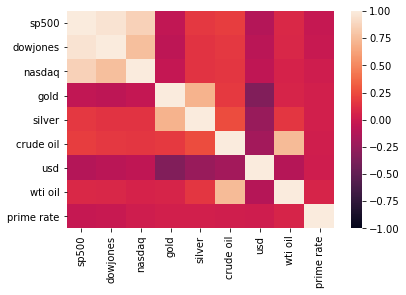

In [13]:
sns.heatmap(oil_commodities_corr, vmin=-1, vmax=1)

<AxesSubplot:title={'center':'Oil & Commodoties Plot'}>

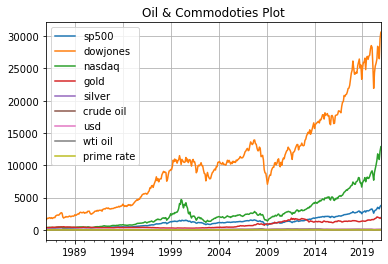

In [14]:
oil_commodities_sp500.plot(y=['sp500', 'dowjones', 'nasdaq', 'gold', 'silver', 'crude oil', 'usd',
       'wti oil','prime rate'],grid=True,title='Oil & Commodoties Plot')

In [15]:
## Adding a second scale 
fig, ax = plt.subplots(1,2)

oil_commodities_sp500['sp500'].plot()
oil_commodities_sp500['usd'].plot(ax=ax[1], label= 'usd', xlabel='year', ylabel='usd & wti',title='Monthly Closing Price',figsize =10,5)
oil_commodities_sp500['wti oil'].plot(ax=ax[1], label= 'wti', color= 'purple',figsize =10,5)

SyntaxError: positional argument follows keyword argument (<ipython-input-15-acf4c6a44181>, line 5)

In [ ]:
gdp_hpi_returns = gdp_hpi_sp500.pct_change()
gdp_hpi_returns.dropna(inplace=True)

gdp_hpi_corr = gdp_hpi_returns.corr()
gdp_hpi_corr.head()

In [ ]:
sns.heatmap(gdp_hpi_corr, vmin=-1, vmax=1)

In [ ]:
gdp_hpi_sp500.plot(y=['sp500', 'gdp','interest rate','house price index'],grid=True,title='GDP, Interest Rate & Housing Price Index Plot')

## Plotting Graph for Analysis 

In [16]:
prices_commodities = oil_commodities_sp500[["sp500","gold","silver","crude oil"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
prices_gold = oil_commodities_sp500[["sp500","gold"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
prices_silver = oil_commodities_sp500[["sp500","silver"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
prices_crudeoil = oil_commodities_sp500[["sp500","crude oil"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
oil_price = oil_commodities_sp500[['sp500','wti oil']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
usd_price = oil_commodities_sp500[['sp500','usd']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
prime_rate = oil_commodities_sp500[['sp500','prime rate']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
all_price = oil_commodities_sp500[['sp500','wti oil', 'usd']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")

In [17]:
gdp_sp500_plot = gdp_hpi_sp500[['sp500','gdp']].hvplot.line(xlabel='Date',ylabel='Quarterly Change')
ir_sp500_plot = gdp_hpi_sp500[['sp500','interest rate']].hvplot.line(xlabel='Date',ylabel='Quarterly Change')
hpi_sp500_plot = gdp_hpi_sp500[['sp500','house price index']].hvplot.line(xlabel='Date',ylabel='Quarterly Change')

In [18]:
rolling_corr = oil_commodities_return.rolling(window=12).corr().dropna()
rolling_corr.reset_index(inplace=True)
rolling_corr.rename(columns={"level_0":"Date"},inplace=True)
rolling_corr.set_index("Date",inplace=True)
rolling_corr.head()

,level_1,sp500,dowjones,nasdaq,gold,silver,crude oil,usd,wti oil,prime rate
Date,,,,,,,,,,
2019-04-01,sp500,1.000000,0.994291,0.977442,0.405374,0.690350,0.729474,-0.347121,0.117036,-0.154778
2019-04-01,dowjones,0.994291,1.000000,0.954489,0.382215,0.687154,0.744426,-0.317111,0.169584,-0.132267
2019-04-01,nasdaq,0.977442,0.954489,1.000000,0.425165,0.635772,0.636342,-0.333173,-0.004111,-0.193099
2019-04-01,gold,0.405374,0.382215,0.425165,1.000000,0.708173,0.136360,-0.424108,-0.286351,-0.016548
2019-04-01,silver,0.690350,0.687154,0.635772,0.708173,1.000000,0.683401,-0.326315,0.270541,0.165940


In [19]:
gdp_rolling_corr = gdp_hpi_returns.rolling(window=12).corr().dropna()
gdp_rolling_corr.reset_index(inplace=True)
gdp_rolling_corr.rename(columns={"level_0":"Date"},inplace=True)
gdp_rolling_corr.set_index("Date",inplace=True)
gdp_rolling_corr.head()

NameError: name 'gdp_hpi_returns' is not defined

In [ ]:
gold_corr = rolling_corr[rolling_corr['level_1'] == 'gold'].sp500
crude_oil_corr = rolling_corr[rolling_corr['level_1'] == 'crudeoil'].sp500 
silver_corr = rolling_corr[rolling_corr['level_1'] == 'silver'].sp500
dowjones_corr = rolling_corr[rolling_corr['level_1'] == 'dowjones'].sp500
sp500_corr = rolling_corr[rolling_corr['level_1'] == 'sp500'].sp500
dxy_oil_corr = rolling_corr[rolling_corr['level_1'] == 'crude oil'].sp500
wti_corr = rolling_corr[rolling_corr['level_1'] == 'wti oil'].sp500
prime_corr = rolling_corr[rolling_corr['level_1'] == 'prime rate'].sp500
hpi_corr = gdp_rolling_corr[gdp_rolling_corr['level_1'] == 'hpi'].sp500
gdp_corr = gdp_rolling_corr[gdp_rolling_corr['level_1'] == 'gdp'].sp500
interest_corr = gdp_rolling_corr[gdp_rolling_corr['level_1'] == 'interest rate'].sp500

In [21]:
tickers = [
          "BTC-USD",
          "ETH-USD",
          "^GSPC"
          ]

df_crypto = yf.download(tickers,
start="1980-01-01",
end="2021-01-29",
progress=False,
interval = "1mo",
groupby = "ticker"
                )

In [22]:
df_crypto.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

In [23]:
df_crypto.rename(columns=
          {"BTC-USD":"btc",
             "ETH-USD":"eth",
             "^GSPC":"sp500",
            },inplace=True)

In [24]:
df_crypto.columns = df_crypto.columns.droplevel(level=0)
df_crypto.dropna(inplace=True)
df_crypto_return = df_crypto.pct_change()
df_crypto_corr = df_crypto_return.corr()

In [25]:
df_crypto_rolling_corr = df_crypto_return.rolling(window=12).corr().dropna()
df_crypto_rolling_corr.reset_index(inplace=True)
df_crypto_rolling_corr.set_index("Date",inplace=True)
df_crypto_rolling_corr.head()

,level_1,btc,eth,sp500
Date,,,,
2016-09-01,btc,1.000000,-0.177658,0.287968
2016-09-01,eth,-0.177658,1.000000,-0.207934
2016-09-01,sp500,0.287968,-0.207934,1.000000
2016-10-01,btc,1.000000,-0.199912,-0.077153
2016-10-01,eth,-0.199912,1.000000,-0.141507


In [26]:
btc_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == 'btc'].sp500
eth_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == 'eth'].sp500


In [28]:
def comm_correlation():
    comm_corr = oil_commodities_corr.hvplot.heatmap(title = "Commodities and Indices Correlation")    
    return comm_corr
def crypto_correlation():
    crypto_corr = df_crypto_corr.hvplot.heatmap(title = "Crytocurrencies and Indices Correlation")    
    return crypto_corr


list_of_commodities = ["gold","silver","crude oil"]
def commodities_price(commodities):
    comm_price = oil_commodities_sp500[["sp500",commodities]].hvplot.line(title = f"Price of {commodities} and S&P500",
                                                                           xlabel="Date", ylabel="Monthly Close Price",ylim=(0,4000))
    return comm_price

def commodities_correlation(commodities):
    comm_corr = rolling_corr[rolling_corr['level_1'] == commodities].sp500
    return comm_corr.hvplot.line(title = f"{commodities} & S&P500 12 month Rolling Correlation", xlabel="Date", ylabel="Correlation")

def econ_correlation(commodities):
    econ_corr = gdp_rolling_corr[gdp_rolling_corr['level_1'] == commodities].sp500
    return econ_corr.hvplot.line(title = f"{commodities} & S&P500 12 month Rolling Correlation", xlabel="Date", ylabel="Correlation")


list_of_crypto = ["btc","eth"]
def cryptocurrency_price(crypto):
    crypto_price = df_crypto[["sp500",crypto]].hvplot.line(title = f"Price of {crypto} and S&P500",
                                                                           xlabel="Date", ylabel="Monthly Close Price")
    return crypto_price
    
def cryptocurrency_corr(crypto):
    crypto_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == crypto]
    return crypto_corr.sp500.hvplot.line(title = f"{crypto} and S&P500 12 month Rolling Correlation",
                                                                           xlabel="Date", ylabel="Correlation")
                                                                           
def oil_commodities_correlation():
    oil_commodities_correlation = oil_commodities_corr.hvplot.heatmap(title = "USD, Oil and S&P500 Correlation")    
    return oil_commodities_correlation


list_of_stock = ["sp500","dxy_mthly","wti_mthly"]
def stock_price(stock):
    stock_price = oil_commodities_sp500[["sp500",stock]].hvplot.line(title = f"Price of {stock} and S&P500",
                                                                           xlabel="Date", ylabel="Monthly Close Price",ylim=(0,4000))
    return stock_price

def stock_correlation(stock):
    stock_corr = rolling_corr[rolling_corr['level_1'] == stock].sp500
    return stock_corr.hvplot.line(title = f"{stock} & S&P500 12 month Rolling Correlation", xlabel="Date", ylabel="Correlation")

In [37]:
comm_summary = pn.Column("#S&P 500 and Commodities Summary", commodities_price, comm_correlation())
crypto_summary = pn.Column("#S&P 500 and Cryptocurrencies Summary", df_crypto.hvplot.line(xlabel="Date", ylabel="Monthly Close Price"), crypto_correlation())
comm_analysis = pn.Column("#Commodities Analysis", interact(commodities_price, commodities=list_of_commodities), interact(commodities_correlation,commodities=list_of_commodities))
crypto_analysis = pn.Column("#Cryptocurrencies Analysis", interact(cryptocurrency_price, crypto=list_of_crypto), interact(cryptocurrency_corr,crypto=list_of_crypto))
stock_summary = pn.Column("#Stock and S&P500 Summary", all_price, oil_commodities_correlation)
stock_analysis = pn.Column("#Stock Analysis", interact(stock_price, stock =list_of_stock), interact(stock_correlation, stock=list_of_stock))
gdp_hpi_row = pn.Row(gdp_sp500_plot)
panel1=pn.Tabs(
    ("Commodities Summary",comm_summary), ("Commodities Analysis",comm_analysis))
panel2=pn.Tabs(("Cryptocurrencies Summary", crypto_summary),("Cryptocurrencies Analysis",crypto_analysis))


comm_summary = pn.Column("#S&P 500 and Commodities Summary", prices_commodities, comm_correlation())
crypto_summary = pn.Column("#S&P 500 and Cryptocurrencies Summary", df_crypto.hvplot.line(xlabel="Date", ylabel="Monthly Close Price"), crypto_correlation())
comm_analysis = pn.Column("#Commodities Analysis", interact(commodities_price, commodities=list_of_commodities), interact(commodities_correlation,commodities=list_of_commodities))
crypto_analysis = pn.Column("#Cryptocurrencies Analysis", interact(cryptocurrency_price, crypto=list_of_crypto), interact(cryptocurrency_corr,crypto=list_of_crypto))
panel1=pn.Tabs(
    ("Commodities Summary",comm_summary), ("Commodities Analysis",comm_analysis))
panel2=pn.Tabs(("Cryptocurrencies Summary", crypto_summary),("Cryptocurrencies Analysis",crypto_analysis))



panel3=pn.Tabs(("Stock Summary",stock_summary), ("Stock Analysis",stock_analysis))
Summary = pn.Column("## General Summary",gdp_sp500_plot, ir_sp500_plot, hpi_sp500_plot)
Analysis = pn.Column("## Analysis", gdp_hpi_returns,ir_sp500_plot,gdp_sp500_plot)
panel4= pn.Tabs(("Summary", Summary), ("Analysis", Analysis))

ValueError: cannot find widget or abbreviation for argument: 'commodities'

NameError: name 'commodities' is not defined

## Presidential Analysis

In [31]:
real_gdp_returns= real_gdp.pct_change()
real_gdp_returns.dropna(inplace=True)
real_gdp_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 1980-04-01 to 2020-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     163 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [32]:
real_gdp_returns.head()

,gdp
DATE,
1980-04-01,-0.023314
1980-07-01,-0.004176
1980-10-01,0.015889
1981-01-01,0.017520
1981-04-01,-0.009665


In [33]:
ir_returns= ir_data.pct_change()
ir_returns.dropna(inplace=True)
ir_returns.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 1980-04-01 to 2020-10-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   interest rate  163 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [34]:
ir_returns.head()

,interest rate
DATE,
1980-04-01,-0.023314
1980-07-01,-0.004176
1980-10-01,0.015889
1981-01-01,0.017520
1981-04-01,-0.009665


In [35]:
real_gdp_pres= real_gdp.iloc[::-1] #backward
real_gdp_pres= real_gdp.iloc[0:160:4] #0-160 return every 4
real_gdp_pres_plot= real_gdp_pres.iloc[0:160:4].hvplot.line(title="GDP (1981 - 2020)")
SP500_pres_data = yf.download('^GSPC',
    start='1970-01-01',
    end='2020-10-01',
    interval='3mo',
    progress=False)

# Display sample data
SP500_pres_data.drop(columns= {'Open','High','Low','Adj Close','Volume'},inplace =True)
SP500_pres_data. rename (columns = {"Close": "SP_500"},inplace = True)
SP500_pres= SP500_pres_data.iloc[::-1]
SP500_pres= SP500_pres.iloc[0:160:4] 
SP500_pres_plot =SP500_pres .iloc[0:160:4].hvplot.line(title=" S&P 500 (1981 - 2020)", xlabel="Date")

### Plot Graph according to Presidental Duration

In [36]:
reagan_gdp= real_gdp_pres.iloc[0:9].hvplot.line(title="GDP 1981 - 1988 (Ronald Regan)")
reagan_SP = SP500_pres.iloc[32:40].hvplot.line(title="S&P500 - 1981 - 1988 (Ronald Regan)")
bush_SR_gdp= real_gdp_pres.iloc[9:13].hvplot.line(title="GDP 1989 - 1992 (George H.W.Bush)")
bush_SR_SP = SP500_pres.iloc[28:33].hvplot.line(title="S&P500 - 1989 - 1992 (George H.W.Bush)")
clinton_gdp = real_gdp_pres.iloc[13:21].hvplot.line(title="Real GDP 1993 - 2000 (Bill Cliton)")
clinton_SP= SP500_pres.iloc[20:28].hvplot.line(title="S&P500 - 1993 - 2000 (Bill Cliton)")
bush_JR_gdp = real_gdp_pres.iloc[21:29].hvplot.line(title="GDP 2001 - 2008 (George W.Bush)")
bush_JR_SP= SP500_pres.iloc[12:20].hvplot.line(title="S&P500 - 2001 - 2008 (George W.Bush)")
obama_gdp = real_gdp_pres.iloc[29:37].hvplot.line(title="GDP 2009 - 2016 (Barack Obama)")
obama_SP = SP500_pres.iloc[4:12].hvplot.line(title="S&P500 - 2009 - 2016 (Barack Obama)")
trump_gdp = real_gdp.iloc[150:164:4].hvplot.line(title="GDP 2017 - 2020 (Donald Trump)")
trump_SP= SP500_pres.iloc[0:5].hvplot.line(title=" S&P500 - 2017 - 2020 (Donald Trump)")

In [37]:
reagan = pn.Row(reagan_SP,reagan_gdp)
bush_SR = pn.Row(bush_SR_SP, bush_SR_gdp)
clinton = pn.Row(clinton_SP, clinton_gdp)
bush_JR = pn.Row(bush_JR_SP, bush_JR_gdp)
obama = pn.Row(obama_SP, obama_gdp)
trump = pn.Row(trump_SP, trump_gdp)

### Dashboard

In [38]:
panel1.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(HeatMap)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column
                [0] Select(name='commodities', options=['gold', 'silver', ...], value='gold')
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive02866')
        [2] Column
            [0] Column
                [0] Select(name='commodities', options=['gold', 'silver', ...], value='gold')
            [1] Row
                [0] HoloViews(Curve, name='interactive02973')

From 1985 to early 2000, gold was used to hedge against market downturn. When investers were expecting a bear market, they sell shares in stock market and buy gold, causing decline in stock market indices and rise in gold prices. Hence, gold price moved in the opposite direction of S&P500 index.
This is also shown as negative (inverse) correlation until early 2000. The correlation started to change to be more positive due to creation of paper gold and commodities market in 1970's. However, it took some time for the paper gold and commdities futures market to be popularized and accessible to retial investors; therefore, the transition was not apparent until mid 2000's. The commodities market allowed traders and investors to speculate on future commodities prices. As a result, the gold price correlation began to shift to possitive territory. Since 2007, we noticed that Crude Oil has become more collerated to S&P500, possibly due to the start of oil price war.



Cryptocurrencies has weak correlation to S&P500.

In [39]:
panel2.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(HeatMap)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column
                [0] Select(name='crypto', options=['btc', 'eth'], value='btc')
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive03060')
        [2] Column
            [0] Column
                [0] Select(name='crypto', options=['btc', 'eth'], value='btc')
            [1] Row
                [0] HoloViews(Curve, name='interactive03167')

In [40]:
panel3.servable()

Tabs
    [0] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(HeatMap)

In [41]:
panel4.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(NdOverlay)
        [3] HoloViews(NdOverlay)
    [1] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame)
        [2] HoloViews(NdOverlay)
        [3] HoloViews(NdOverlay)

From the heat map we could observe that there is little to no correlation between the Stock market and interest rate.
GDP seems similar to S&P 500 line trends postively and the heat map show little to no correlation

In [42]:
reagan

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

In [43]:
bush_SR

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

In [44]:
clinton 

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

In [45]:
bush_JR 

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

In [46]:
obama   

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

In [47]:
trump

Row
    [0] HoloViews(Curve)
    [1] HoloViews(Curve)

President's impact on the economy (Stock Market) has a little impact on growth and changes in stock market observing the S&P 500 growing postively through all years regardless of the president.

GDP seems similar to S&P 500 line trends postively regardless of president.

## Aidan's Section

<AxesSubplot:title={'center':'Rolling 14-day Beta USD and S&P 500'}>

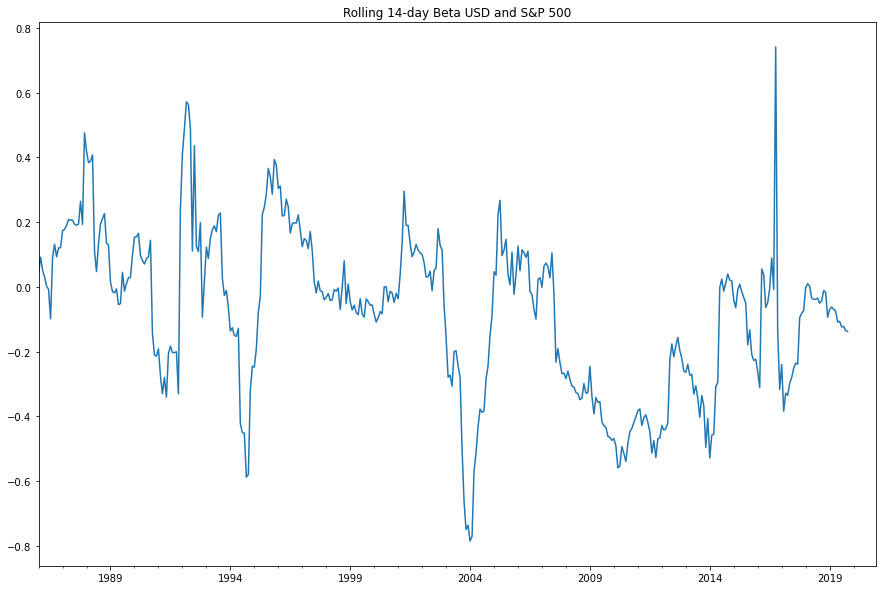

In [48]:
##Rolling beta S&P500 and USD
rolling_cov = oil_commodities_return['sp500'].rolling(window=14).cov(oil_commodities_return["usd"])
rolling_var = oil_commodities_return['sp500'].rolling(window=14).var()
rolling_beta = rolling_cov / rolling_var
rolling_beta.plot(figsize=(15,10), title = "Rolling 14-day Beta USD and S&P 500")

<AxesSubplot:title={'center':'Rolling 14-day Beta WTI Oil and S&P 500'}>

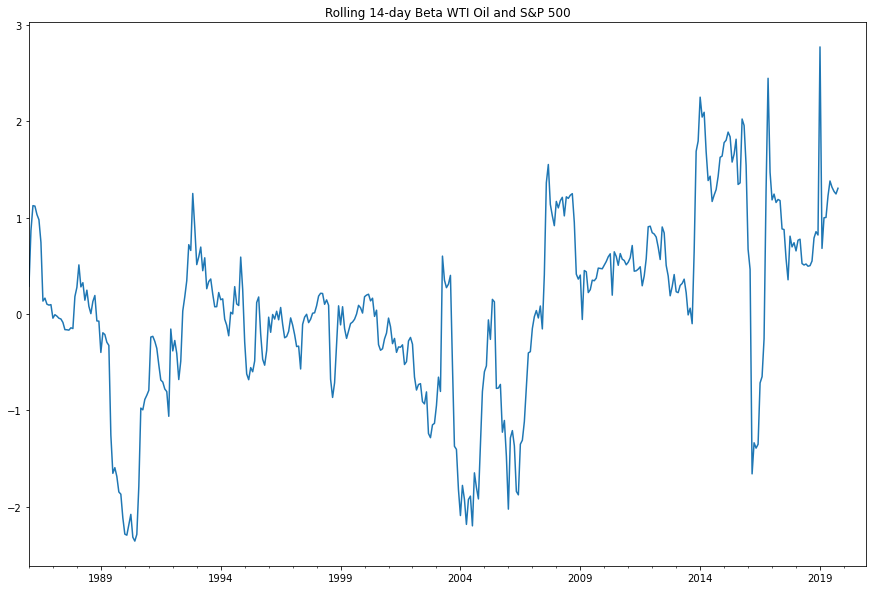

In [49]:
##Rolling beta S&P500 and WTI
rolling_cov = oil_commodities_return['sp500'].rolling(window=14).cov(oil_commodities_return["wti oil"])
rolling_var = oil_commodities_return['sp500'].rolling(window=14).var()
rolling_beta = rolling_cov / rolling_var
rolling_beta.plot(figsize=(15,10), title = "Rolling 14-day Beta WTI Oil and S&P 500")